In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from EM import EM
from scipy.stats import t, expon, norm

# Sampler

In [26]:
import numpy as np
from scipy.stats import t, expon, norm
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn

def param_to_input(r,epsilon_past,r_past,alpha_r, beta_r, d, alpha_u, beta_u,gamma, theta, _lambda):
    #epsilon_past is of shape (n,) everying else scalers
    n=epsilon_past.shape[0]
    output=torch.zeros(n,3)
    u_past=(r_past-alpha_r-epsilon_past)/beta_r
    output[:,0]=alpha_u+beta_u*u_past+gamma*epsilon_past**2+theta*(epsilon_past<0)*epsilon_past**2
    output[:,1]=r-alpha_r
    output[:,2]=beta_r

    return output

class VIScaler(nn.Module):
    def __init__(self, hidden_size=16):
        super().__init__()
        self.fc1 = nn.Linear(3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x=  1e-2+torch.sigmoid(x)
        return x

class TEST_SAMPLER:
    """test sampler"""
    ESS_list = []
    sample_num = 1
    def __init__(self, T, params,path="VIScaler_best.pth"):
        self.alpha_r, self.beta_r, self.d, self.alpha_u, self.beta_u,self.gamma, self.theta, self._lambda = params
        # print(params)
        self.params = params
        self.T = T
                
        self.model=VIScaler(hidden_size=16)
        self.model=torch.load(path)
        self.model.eval()

    def log_likelihood_update(self,epsilon,r,epsilon_past,r_past):
        ''' Compute log joint likelihood of l=log p(eps_t,r_t|eps_{t-1},r_{t-1})'''
        #Input:  epsilon  (n,) epsilon_past  (n,)  r (1,) r_past (1,)
        #Output: log_prob (n,)

        prior=0 #do we need prior on r_0, eps_0?

        ''' Calculate u, w, nu and eta'''
        #u=(r-epsilon-self.alpha_r)/self.beta_r
        u_past= (r_past-epsilon_past-self.alpha_r)/self.beta_r

        w=self.alpha_u+self.beta_u*u_past+(self.gamma+self.theta*(epsilon_past<0))*(epsilon_past**2)

        #print("min r-eps-alpha_r:",np.min(r-epsilon-self.alpha_r))

        nu=np.sqrt(self.beta_r/(r-epsilon-self.alpha_r+1e-6))*epsilon
        #nu=np.where(np.isnan(nu),1e10,nu)
        eta=(r-epsilon-self.alpha_r+1e-6)/self.beta_r-w
        #eta=np.maximum(eta,1e-7)
        #print(f"eps:{epsilon[:10]}\n eps_past:{epsilon_past[:10]}\n r:{r} r_past:{r_past} etamin:{eta.min()}\n w:{w[:10]}, nu:{nu[:10]}\n eta:{eta[:10]}\n")
        #print(eta.min())
        #eta=np.where(np.isnan(eta),1e6,eta)
        #eta=np.where(eta<0,1e8,eta)
        #eta=(eta>=0)*eta+(eta<=0)*1e-6
        #assert eta.min()>=0 #eta should follow exponential distribution

        #logp_exp=expon.logpdf(eta, scale=1/self._lambda)
        logp_exp=norm.logpdf(eta, scale=0.5)
        logp_t=t.logpdf(nu,self.d)


        log_joint=logp_exp+logp_t -0.5*(np.log(self.beta_r)+np.log(r-epsilon-self.alpha_r+1e-6))+prior
        #log_joint=np.where(np.isnan(log_joint),-1e10,log_joint)
        #print(log_joint)
        return log_joint
        
    def sample(self, sample_num:int, r, exp_scale=1, resample_thre=0.5):
        self.ESS_list = []
        self.sample_num = sample_num
        
        samples = np.zeros((sample_num,self.T))
        log_weights = np.zeros(sample_num)
        eps=np.zeros(sample_num)
        r_past=self.alpha_r
        for i in range(self.T): 
            # print(f"----------STEP{i}----------")
            #pdb.set_trace()
            rr=r[i]
            eps_past=eps.copy()
            u_past= (r_past-eps_past-self.alpha_r)/self.beta_r
            w=self.alpha_u+self.beta_u*u_past+(self.gamma+self.theta*(eps_past<0))*(eps_past**2)
            eps,log_density = self.policy(eps_past, rr, w, exp_scale,r_past)
           

            # print(f"step{i}\n eps:{eps}\n eps_past:{eps_past} \n rr:{rr} w:{w} exp_scale:{exp_scale}\n")
            log_weights += self.log_likelihood_update(eps,rr,eps_past,r_past)-log_density          #self.log_policy_density(eps, rr, w, exp_scale,r_past)
            if np.isnan(log_density).sum()+np.isnan(eps).sum() + np.isnan( log_weights).sum()>0:
                print(f"NaN encountered in sampling steps{i}")
                print(f"Parameters:{self.params}")


            
            r_past=rr
            samples[:,i]=eps
            weights=np.exp(log_weights)
            weights=weights/weights.sum()
            
            ESS = 1/np.sum(np.power(weights, 2))
            self.ESS_list.append(ESS)
            if ESS < sample_num:
                samples[:,:i] = self.resample(samples[:,:i], weights)
                weights = np.ones(sample_num)/sample_num
                log_weights=np.zeros(sample_num)
                eps=samples[:,i]
        return samples, weights
    
    def plot_ESS(self, y_high=0, title=""):
        if y_high == 0:
            y_high = self.sample_num
        plt.plot(range(self.T), self.ESS_list)
        plt.ylim(0, y_high)
        plt.xlim(0, self.T)
        plt.ylabel("ESS")
        if title != "":
            plt.title(title)
        plt.show()
        plt.clf()
    
    def resample(self, samples, weights):
        index = np.random.choice(list(range(len(weights))), p=weights, size=(len(weights)))
        return samples[index]
    
    def policy(self, eps_past, rr, w, exp_scale,r_past):
        # print("exponentials:",expon.rvs(scale=exp_scale,size=self.sample_num))
        # print("values:",rr,self.alpha_r,self.beta_r*w,self.beta_r*np.random.exponential(scale=exp_scale,size=self.sample_num))
        #print("generate eps:",rr-self.alpha_r-self.beta_r*w-self.beta_r*np.random.exponential(scale=exp_scale,size=self.sample_num))
        inputs=param_to_input(torch.tensor(rr),torch.tensor(eps_past),torch.tensor(r_past),torch.tensor(self.alpha_r),torch.tensor(self.beta_r),
                              torch.tensor(self.d),torch.tensor(self.alpha_u),torch.tensor(self.beta_u),torch.tensor(self.gamma),
                              torch.tensor(self.theta),torch.tensor(self._lambda))
        outputs = self.model(inputs).reshape(-1)
        assert torch.tensor(eps_past).shape[0]==outputs.shape[0]
        #outputs=torch.tensor(0.4).expand(inputs.shape[0],)
        #print(outputs)
        base=torch.distributions.Exponential(1).sample((inputs.shape[0],)).reshape(-1)
        sample=torch.tensor(rr)-torch.tensor(self.alpha_r)-base*outputs
        return sample.detach().numpy(),(torch.distributions.Exponential(1).log_prob(base)-torch.log(outputs)).detach().numpy()
        #return rr-self.alpha_r-expon.rvs(scale=exp_scale,size=self.sample_num)
    #np.random.exponential(scale=exp_scale,size=self.sample_num) #a simple policy
    
    def policy_old(self, eps_past, rr, w, exp_scale,r_past):
        eps=rr-self.alpha_r-expon.rvs(scale=exp_scale,size=self.sample_num)
        return eps, expon.logpdf((rr-self.alpha_r-eps),scale=exp_scale)
    
    def log_policy_density(self, eps, rr, w, exp_scale,r_past):
        #Now combined in policy()


        # print("exponential values:",(rr-self.alpha_r-self.beta_r*w-eps)/self.beta_r)
        # print("logpdf:",expon.logpdf((rr-self.alpha_r-self.beta_r*w-eps)/self.beta_r,scale=exp_scale))
        return expon.logpdf((rr-self.alpha_r-eps),scale=exp_scale)





# Posterior Garch

In [47]:
import torch
import numpy as np
from torch.distributions import StudentT, Exponential, Normal
from sampler import *
from tqdm import tqdm

import torch.optim as optim
def generate_grid_samples(n, T,lower=0,upper=0):
    """
    Generates grid samples of size n that cover most of the [-1, 1]^T space.

    Parameters:
    n (int): Number of samples to generate.
    T (int): Number of dimensions.

    Returns:
    torch.Tensor: Tensor of shape (n, T) containing the generated samples.
    """
    # Determine the number of points per dimension (rounded to the nearest integer)
    points_per_dim = int(torch.ceil(torch.tensor(n ** (1 / T))).item())

    # Create a grid of points in each dimension
    grid_list = [torch.linspace(lower[t],upper[t], points_per_dim)for t in range(T)] 

    # Generate all combinations of grid points (this can be very large)
    mesh = torch.meshgrid(grid_list, indexing='ij')
    grid_samples = torch.stack(mesh, dim=-1).reshape(-1, T)

    # Shuffle the grid samples to introduce some randomness
    perm = torch.randperm(grid_samples.size(0))
    grid_samples = grid_samples[perm]

    # If there are more grid samples than required, select n of them
    if grid_samples.size(0) > n:
        grid_samples = grid_samples[:n]
    
    # If there are fewer grid samples than required, repeat some of them to reach n
    while grid_samples.size(0) < n:
        additional_samples = grid_samples[:min(grid_samples.size(0), n - grid_samples.size(0))]
        grid_samples = torch.cat([grid_samples, additional_samples], dim=0)

    return grid_samples
class POSTGARCH:
    def __init__(self, T=100, _alpha_r=0, _beta_r=1, _d=1, _alpha_u=0, _beta_u=1, _gamma=1, _theta=0, __lambda=1,rfilename="./r.npy"):
        self.alpha_r = torch.tensor(_alpha_r, dtype=torch.float64)
        self.beta_r = torch.tensor(_beta_r, dtype=torch.float64)
        self.alpha_u = torch.tensor(_alpha_u, dtype=torch.float64)
        self.beta_u = torch.tensor(_beta_u, dtype=torch.float64)
        self.gamma = torch.tensor(_gamma, dtype=torch.float64)
        self.theta = torch.tensor(_theta, dtype=torch.float64)
        self._lambda = torch.tensor(__lambda, dtype=torch.float64)
        self.d = torch.tensor(_d, dtype=torch.float64)
        # self.parameters=[self.alpha_r, self.beta_r, self.alpha_u, self.beta_u, self.gamma, self.theta, self._lambda, self.d]
        # self.names=["alpha_r", "beta_r", "alpha_u", "beta_u", "gamma", "theta", "_lambda", "d"]
        self.parameters=[self.alpha_r, self.alpha_u, self.beta_u, self.gamma, self.theta, self._lambda]
        self.names=["alpha_r", "alpha_u", "beta_u", "gamma", "theta", "_lambda"]
        self.T=T
        self.r=np.load(rfilename)
        self.r=torch.tensor(self.r).reshape(1,-1)
        assert self.T ==self.r.shape[1]
    def compute_truth_likelihood(self,n=100000,radius=10,lower=0,upper=0):
        ''' Compute log joint likelihood of l=log p(eps_1,...,eps_T,r_1,...r_T)'''
        #Input:  epsilon  (n,T)
        #Output: log_prob (n,)
        epsilon=generate_grid_samples(n, self.T,lower=lower,upper=upper)

        T=self.T
        prior=0 #do we need prior on r_0, eps_0?

        ''' Calculate u, w, nu and eta'''
        epsilon_shift=torch.zeros(n,T)
        epsilon_shift[:,1:]=epsilon[:,:T-1] #eps_{t-1}
        u=(self.r-epsilon-self.alpha_r)/self.beta_r
        u_shift=torch.zeros_like(u) #u_{t-1}
        u_shift[:,1:]=u[:,:T-1]
        w=self.alpha_u+self.beta_u*u_shift+(self.gamma+self.theta*(epsilon_shift<0))*(epsilon_shift**2)


        nu=torch.where(self.r-epsilon-self.alpha_r>=0,torch.sqrt(self.beta_r/(self.r-epsilon-self.alpha_r+1e-6))*epsilon,1e8)  
        eta=(self.r-epsilon-self.alpha_r)/self.beta_r-w


        ''' Calculate each component of the log-likelihood'''
        t_distr=StudentT(self.d)
        exp_distr=Normal(loc=0,scale=0.5) #remains to be checked: lambda or 1/lambda
        
        #nu=torch.where(torch.isnan(nu),1e5,nu)
        #nu=(torch.abs(nu)<1e10)*nu+(torch.abs(nu)>=1e10)*1e10
        try:
            logp_t=t_distr.log_prob(nu)
        except:
            print("error encountered in computing the truth likelihood:",nu.min(),nu.max())
            self.state_EM()
            logp_t=torch.ones_like(nu)*(-100000)
        logp_exp=exp_distr.log_prob(eta)
        #print("logp_t:",logp_t)
        #print("logp_exp",logp_exp)
        logp_numer=torch.where(self.r-epsilon-self.alpha_r>=0,torch.log(self.beta_r)+torch.log(self.r-epsilon-self.alpha_r),1e10)


        log_joint=torch.sum(logp_t+logp_exp -0.5*logp_numer, dim=-1)+prior

        radius=torch.tensor(upper-lower)
        return torch.log(torch.sum(torch.exp(log_joint))/n) +(torch.sum(torch.log(radius)))


In [49]:
from tqdm import tqdm
gmodel=POSTGARCH(2,0, 0.2, 6.0, 2, 0.4, 0.1, 0.02, 2.5,rfilename="./r.npy")
alpha_r_list=torch.linspace(-5,20,100)
post_list=[]
for alpha_r in tqdm(alpha_r_list):
    gmodel.alpha_r=alpha_r
    post_list.append(gmodel.compute_truth_likelihood(n=1000000,lower=-20*np.ones(2),upper=20*np.ones(2)))

100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


Text(0, 0.5, 'Posterior Likelihood')

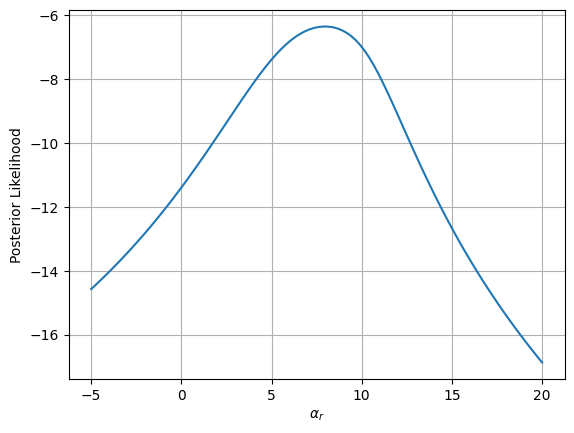

In [50]:
plt.plot(alpha_r_list,post_list)
plt.grid()
plt.xlabel(r"$\alpha_r$")
plt.ylabel("Posterior Likelihood")

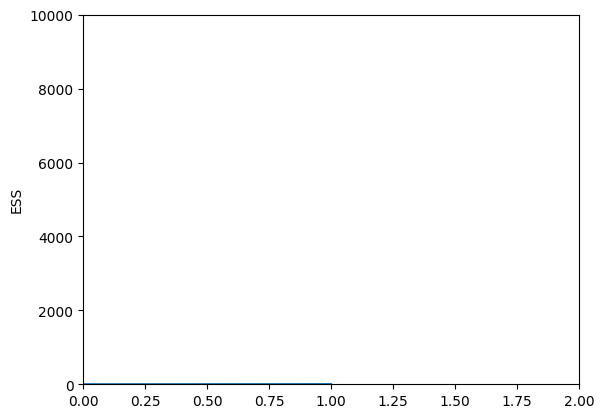

(2, 1) (10000, 2) (10000,)
[[-3.29749115 -1.08680021]
 [-3.27366389 -1.13138174]
 [-3.29749115 -1.0541896 ]
 ...
 [-3.28729905 -1.13542504]
 [-3.29749115 -1.05162657]
 [-3.29749115 -1.1133799 ]]
[0.0001 0.0001 0.0001 ... 0.0001 0.0001 0.0001]


<Figure size 640x480 with 0 Axes>

In [27]:
r=np.load("./r.npy")
params=(2, 0.2, 6.0, 2.0, 0.4, 0.1, 0.02, 2.5)
sampler=TEST_SAMPLER(2,params)
samples,weights=sampler.sample(10000,r,exp_scale=0.8)
sampler.plot_ESS()
print(r.shape,samples.shape,weights.shape)
print(samples)
print(weights)

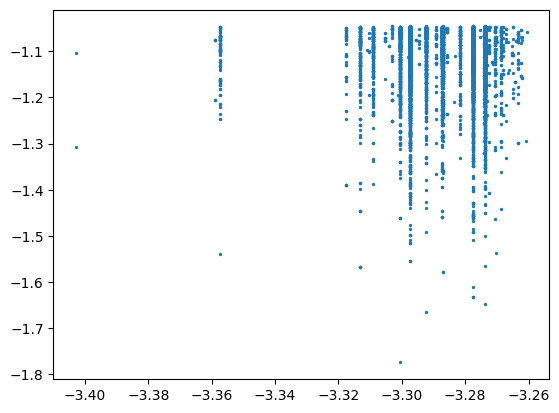

In [28]:
index = np.random.choice(list(range(len(weights))), p=weights, size=(len(weights)))
plt.scatter(samples[:,0][index],samples[:,1][index],s=2)

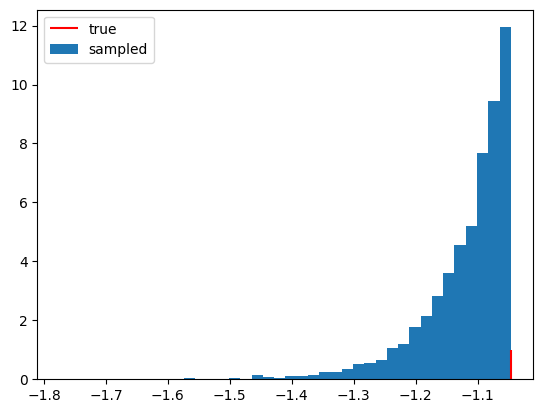

In [33]:
plt.vlines(r[-1]-sampler.alpha_r, ymin=0, ymax=1, color='r', label='true')
plt.hist((samples[:,-1])[index], density=True, weights=weights,bins=40, label="sampled")
plt.legend()
plt.show()